<a href="https://colab.research.google.com/github/oguz81/IsThatTomCruise/blob/main/isthattomcruise.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import os
import numpy as np
import PIL
import PIL.Image
import tensorflow as tf
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import pathlib


In [2]:
import zipfile
dataset_path = "/content/isthattomcruisedataset.zip"


In [3]:
with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall('/content/')

In [4]:
archive = "/content/isthattomcruisedataset"
data_dir = pathlib.Path(archive).with_suffix('')
image_count = len(list(data_dir.glob('*/*.png')))
print(image_count)

350


In [ ]:
tomcruise = list(data_dir.glob('Tom/*'))
PIL.Image.open(str(tomcruise[0]))

In [ ]:
# find out the data type of the image
#type(tomcruise[0])
img_path = "/content/isthattomcruisedataset/Tom/Tom1.png"
img = PIL.Image.open(img_path)
img_array = np.array(img)
print(img_array.dtype)


uint8


In [5]:
batch_size = 64
img_height = 196
img_width = 196

train_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="training",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 350 files belonging to 2 classes.
Using 280 files for training.


In [6]:
val_ds = tf.keras.utils.image_dataset_from_directory(
    data_dir,
    validation_split=0.2,
    subset="validation",
    seed=123,
    image_size=(img_height, img_width),
    batch_size=batch_size
)

Found 350 files belonging to 2 classes.
Using 70 files for validation.


In [7]:
class_names = train_ds.class_names
print(class_names)

['NotTom', 'Tom']


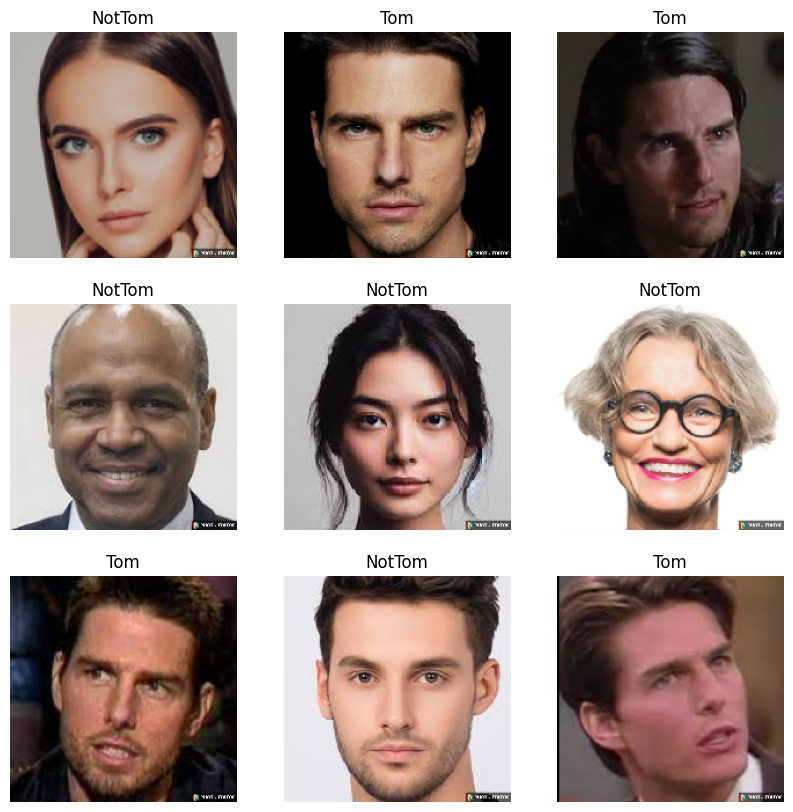

In [9]:
plt.figure(figsize=(10,10))
for images, labels in train_ds.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i+1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

In [ ]:
rescaling = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255)
])

In [ ]:
#check the rescaling
images, labels = next(iter(train_ds))
result = rescaling(images)
print(result.shape)
print(np.min(result))
print(np.max(result))

In [ ]:
# data augmentation
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomContrast(0.5),
    tf.keras.layers.RandomBrightness(0.3),
    tf.keras.layers.Rescaling(1./255)
])

In [ ]:
plt.figure(figsize=(10,10))
for i in range(9):
  augmented_images = data_augmentation(images)
  ax = plt.subplot(3, 3, i+1)
  plt.imshow(augmented_images[2])

In [17]:
AUTOTUNE = tf.data.AUTOTUNE
train_ds = train_ds.cache().prefetch(buffer_size=AUTOTUNE)
val_ds = val_ds.cache().prefetch(buffer_size=AUTOTUNE)

In [18]:
num_classes = len(class_names)
model = tf.keras.Sequential([
    #data_augmentation,
    tf.keras.layers.Rescaling(1./255),
    tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(num_classes)
])

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

In [20]:
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=10
)

Epoch 1/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 14s 2s/step - accuracy: 0.5425 - loss: 1.2593 - val_accuracy: 0.5571 - val_loss: 0.6768
Epoch 2/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5032 - loss: 0.7212 - val_accuracy: 0.4429 - val_loss: 0.7151
Epoch 3/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5260 - loss: 0.6828 - val_accuracy: 0.4429 - val_loss: 0.6760
Epoch 4/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.5260 - loss: 0.6453 - val_accuracy: 0.4714 - val_loss: 0.6786
Epoch 5/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.5745 - loss: 0.6217 - val_accuracy: 0.7429 - val_loss: 0.6527
Epoch 6/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 21s 2s/step - accuracy: 0.7634 - loss: 0.5943 - val_accuracy: 0.7000 - val_loss: 0.6580
Epoch 7/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 12s 2s/step - accuracy: 0.7668 - loss: 0.5345 - val_accuracy: 0.7143 - val_loss: 0.5982
Epoch 8/10
5/5 ━━━━━━━━━━━━━━━━━━━━ 20s 2s/step - accuracy: 0.7859 - loss: 0.5071 - val_accuracy: 0.7571 - val_loss: 0.5366
Epoch 9/

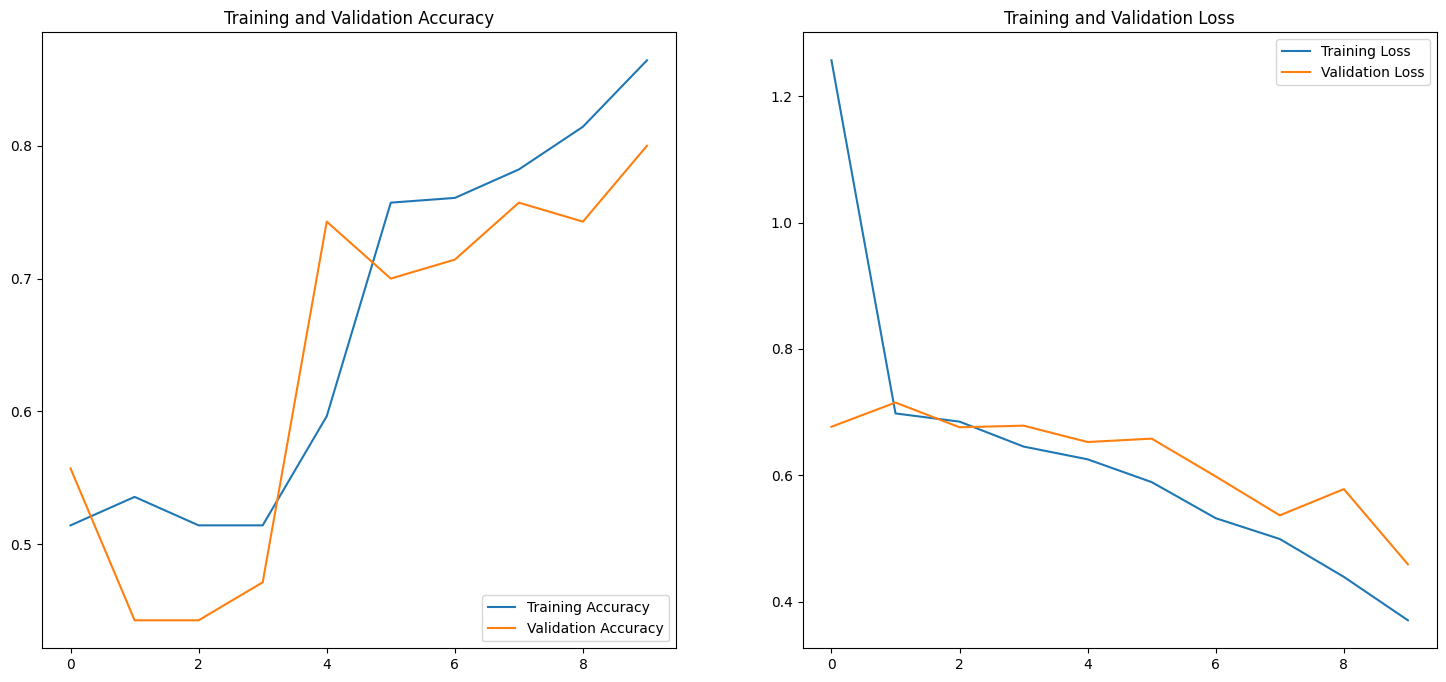

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = 15

plt.figure(figsize=(18, 8))
plt.subplot(1, 2, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

In [ ]:
from tensorflow.keras.preprocessing import image
mytestimage = "/content/test3.png"
img =  image.load_img(mytestimage, target_size=(img_height, img_width))
img_array = image.img_to_array(img)
img_array = tf.expand_dims(img_array, axis=0)
img_array = img_array / 255.0
predictions = model.predict(img_array)
print(predictions)

In [15]:
test_images_path = "/content/newtestimages.zip"
with zipfile.ZipFile(test_images_path, 'r') as zipped:
    zipped.extractall('/content/')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step
[[0.97088456 0.02911545]]


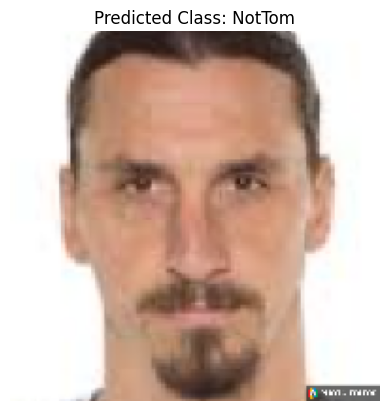

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.5230034  0.47699666]]


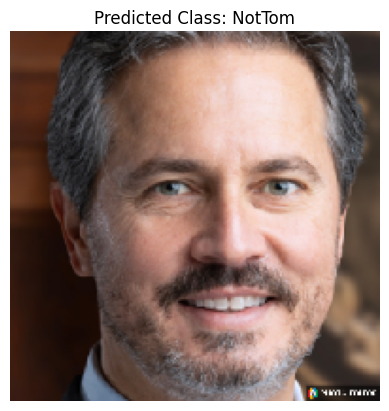

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 31ms/step
[[0.81937754 0.18062247]]


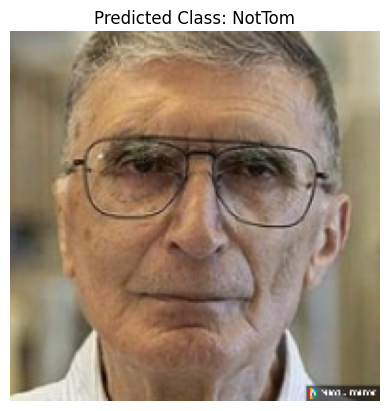

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
[[0.28665793 0.7133421 ]]


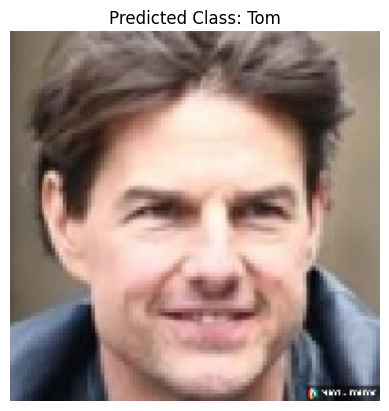

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
[[0.35544103 0.64455897]]


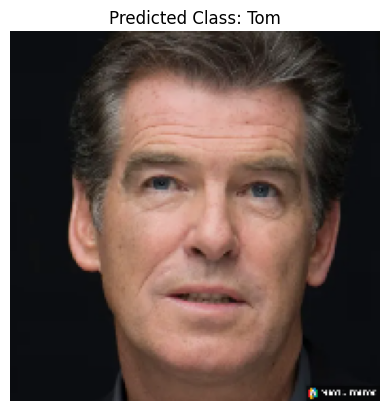

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
[[0.2377871  0.76221293]]


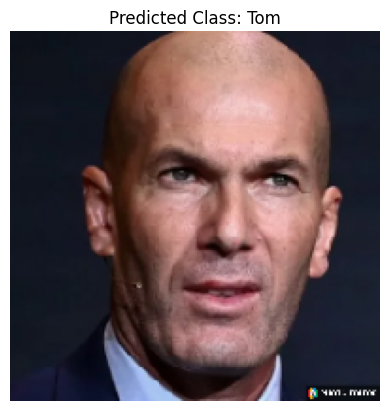

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
[[0.07276689 0.92723316]]


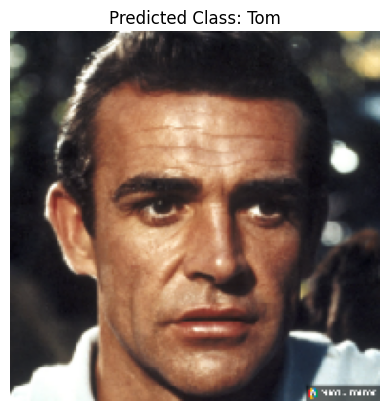

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
[[0.547699 0.452301]]


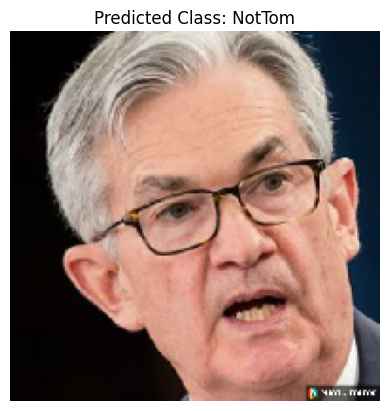

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[[0.3818261  0.61817384]]


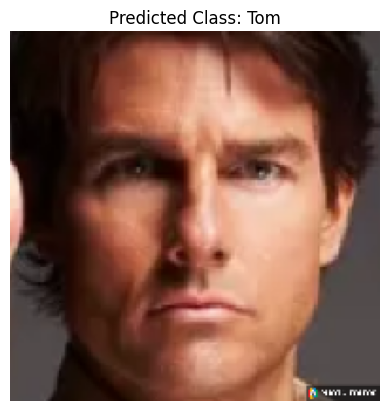

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[[0.41402227 0.58597773]]


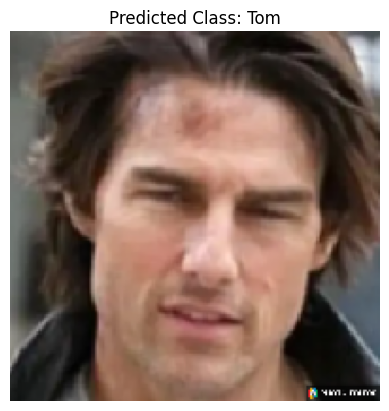

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
[[0.06771917 0.93228084]]


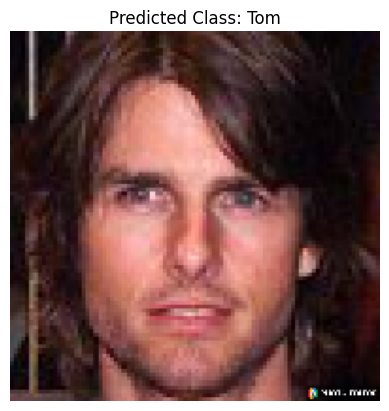

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 74ms/step
[[0.6934281  0.30657184]]


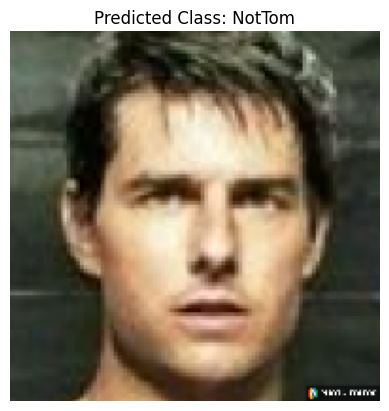

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
[[0.27431965 0.7256804 ]]


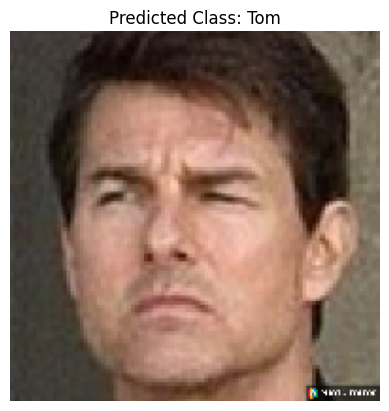

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 62ms/step
[[0.12423093 0.8757691 ]]


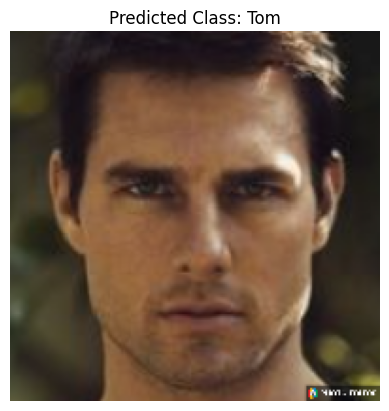

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
[[0.03639684 0.96360314]]


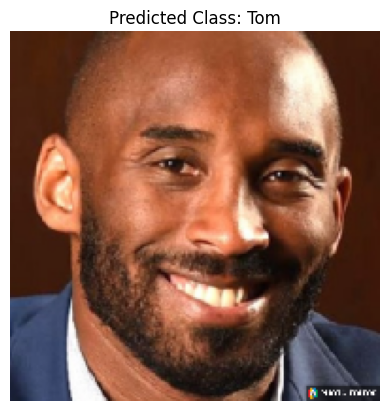

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
[[0.9311824  0.06881768]]


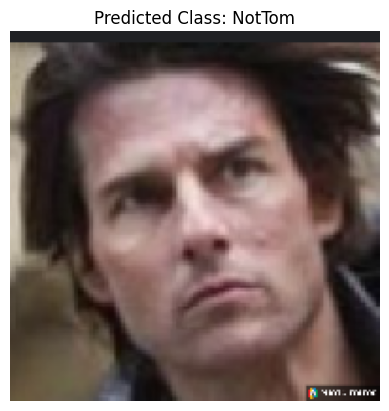

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
[[0.87029094 0.12970905]]


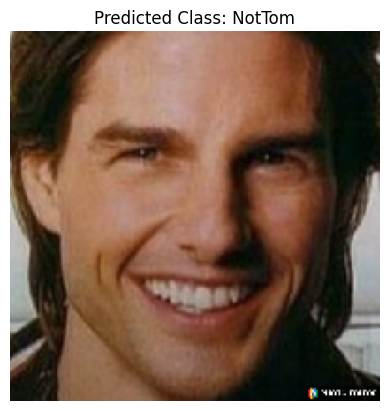

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
[[0.9224163 0.0775837]]


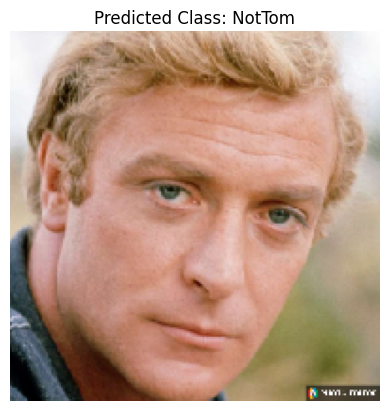

In [24]:
from tensorflow.keras.preprocessing import image
newtestimages = "/content/newtestimages"
image_files = os.listdir(newtestimages)
for image_file in image_files:
    image_path = os.path.join(newtestimages, image_file)
    img = image.load_img(image_path, target_size=(196, 196))
    img_array = image.img_to_array(img)
    img_array = tf.expand_dims(img_array, 0)
    predictions = model.predict(img_array)
    import numpy as np

    probabilities = np.exp(predictions) / np.sum(np.exp(predictions))
    print(probabilities)

    #print("Prediction output:", predictions)
    predicted_class = np.argmax(predictions, axis=-1)
    plt.imshow(img)
    plt.title(f"Predicted Class: {class_names[predicted_class[0]]}")
    plt.axis("off")
    plt.show()

In [ ]:
model.save('bs64_e15_6_9and5_9.keras')